In [1]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


In [2]:
import os
import cv2
import datetime
from torch.utils.tensorboard import SummaryWriter
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer, hooks
from detectron2.config import get_cfg
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.data import build_detection_train_loader, build_detection_test_loader
from detectron2.structures import BoxMode
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.utils.events import CommonMetricPrinter, JSONWriter, EventWriter

# Custom TensorBoard EventWriter
class TensorBoardWriter(EventWriter):
    def __init__(self, log_dir, trainer):
        super().__init__()
        self.writer = SummaryWriter(log_dir=log_dir)
        self.trainer = trainer

    def write(self):
        storage = self.trainer.storage
        iteration = storage.iter
        metrics = storage.latest()

        # Log all scalar metrics to TensorBoard
        for k, v in metrics.items():
            if isinstance(v, (float, int)):
                self.writer.add_scalar(k, v, iteration)

    def after_step(self):
        self.write()

    def close(self):
        self.writer.close()

# Corrected CustomCommonMetricPrinter Class
class CustomCommonMetricPrinter(CommonMetricPrinter):
    def __init__(self, max_iter, trainer):
        super().__init__(max_iter)
        self._max_iter = max_iter
        self.trainer = trainer

    def write(self):
        storage = self.trainer.storage  # Access storage from the trainer object
        iteration = storage.iter
        metrics = storage.latest()
        
        # Print the progress
        print(f"Iteration {iteration}/{self._max_iter} - ", end="")
        for k, v in metrics.items():
            if isinstance(v, (float, int)):
                print(f"{k}: {v:.4f} ", end="")
        print()

        # Call parent write method to handle ETA and other prints
        super().write()

    def _get_eta(self, storage):
        iteration = storage.iter
        try:
            iteration = int(iteration)
            max_iter = int(self._max_iter)  # Ensure max_iter is also an integer
            eta_seconds = storage.history("time").median(1000) * (max_iter - iteration - 1)
            storage.put_scalar("eta_seconds", eta_seconds, smoothing_hint=False)
            return str(datetime.timedelta(seconds=int(eta_seconds)))
        except (ValueError, TypeError) as e:
            print(f"Error calculating ETA: {e}")
            return "N/A"

# Custom trainer class
class MyTrainer(DefaultTrainer):
    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg)

    @classmethod
    def build_evaluator(cls, cfg, dataset_name):
        return COCOEvaluator(dataset_name, output_dir=cfg.OUTPUT_DIR)

    def build_hooks(self):
        hooks_list = super().build_hooks()
        log_dir = os.path.join(self.cfg.OUTPUT_DIR, "tensorboard_logs")
        hooks_list.append(hooks.PeriodicWriter([
            CustomCommonMetricPrinter(self.cfg.SOLVER.MAX_ITER, self),  # Pass self (trainer) to CustomCommonMetricPrinter
            JSONWriter(os.path.join(self.cfg.OUTPUT_DIR, "metrics.json")),
            TensorBoardWriter(log_dir, self)
        ]))
        return hooks_list

    def evaluate_and_log(self):
        evaluator = self.build_evaluator(self.cfg, self.cfg.DATASETS.TEST[0])
        val_loader = build_detection_test_loader(self.cfg, self.cfg.DATASETS.TEST[0])
        results = inference_on_dataset(self.model, val_loader, evaluator)
        
        # Only log scalar metrics
        for k, v in results.items():
            if isinstance(v, (float, int)):
                self.storage.put_scalar(k, v)
            elif isinstance(v, dict):
                for sub_k, sub_v in v.items():
                    if isinstance(sub_v, (float, int)):
                        self.storage.put_scalar(f"{k}_{sub_k}", sub_v)

    def after_step(self):
        super().after_step()
        if self.iter % self.cfg.TEST.EVAL_PERIOD == 0:
            self.evaluate_and_log()

def get_dataset_dicts(img_dir, mask_dir):
    dataset_dicts = []
    for idx, filename in enumerate(os.listdir(img_dir)):
        record = {}

        img_path = os.path.join(img_dir, filename)
        image = cv2.imread(img_path)
        if image is None:
            print(f"Failed to load image: {img_path}")
            continue
        height, width = image.shape[:2]

        record["file_name"] = img_path
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width

        mask_path = os.path.join(mask_dir, filename.replace(".jpg", ".png"))
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        objs = []
        for contour in contours:
            if cv2.contourArea(contour) < 10:
                continue
            bbox = cv2.boundingRect(contour)
            bbox = [bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]]
            obj = {
                "bbox": bbox,
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [contour.flatten().tolist()],
                "category_id": 0,
            }
            objs.append(obj)

        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

def register_dataset(name, img_dir, mask_dir):
    if name in DatasetCatalog.list():
        DatasetCatalog.remove(name)
        MetadataCatalog.remove(name)
    
    DatasetCatalog.register(name, lambda: get_dataset_dicts(img_dir, mask_dir))
    MetadataCatalog.get(name).set(thing_classes=["object"])

train_img_dir = "/vol/bitbucket/ur23/lnd_new_capture/maskrcnn/train/rgb"
train_mask_dir = "/vol/bitbucket/ur23/lnd_new_capture/maskrcnn/train/mask"

val_img_dir = "/vol/bitbucket/ur23/lnd_new_capture/maskrcnn/test/rgb"
val_mask_dir = "/vol/bitbucket/ur23/lnd_new_capture/maskrcnn/test/mask"

register_dataset("my_dataset_train", train_img_dir, train_mask_dir)
register_dataset("my_dataset_val", val_img_dir, val_mask_dir)

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_val",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 8  # Increased batch size
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 1250  # Increased iterations to cover ~10 epochs
cfg.SOLVER.STEPS = []  # To avoid warning about unused steps
cfg.TEST.EVAL_PERIOD = 50  # Evaluate every 50 iterations
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg.INPUT.MASK_FORMAT = "bitmask"
cfg.OUTPUT_DIR = "./output"

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

trainer = MyTrainer(cfg)
trainer.resume_or_load(resume=False)

try:
    trainer.train()
except Exception as e:
    print(f"An error occurred during training: {e}")
finally:
    # Close TensorBoard writer
    for hook in trainer._hooks:
        if isinstance(hook, hooks.PeriodicWriter):
            for writer in hook._writers:
                if isinstance(writer, TensorBoardWriter):
                    writer.close()


[09/02 11:42:41 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in

[09/02 11:42:59 d2.engine.train_loop]: Starting training from iteration 0
ERROR [09/02 11:43:00 d2.engine.train_loop]: Exception during training:
Traceback (most recent call last):
  File "/vol/bitbucket/ur23/detectron2/detectron2/engine/train_loop.py", line 155, in train
    self.run_step()
  File "/vol/bitbucket/ur23/detectron2/detectron2/engine/defaults.py", line 498, in run_step
    self._trainer.run_step()
  File "/vol/bitbucket/ur23/detectron2/detectron2/engine/train_loop.py", line 310, in run_step
    loss_dict = self.model(data)
  File "/vol/bitbucket/ur23/anaconda3/envs/mask/lib/python3.8/site-packages/torch/nn/modules/module.py", line 1553, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/vol/bitbucket/ur23/anaconda3/envs/mask/lib/python3.8/site-packages/torch/nn/modules/module.py", line 1562, in _call_impl
    return forward_call(*args, **kwargs)
  File "/vol/bitbucket/ur23/detectron2/detectron2/modeling/meta_arch/rcnn.py", line 158, in forward
    

In [1]:
import os
import cv2
import datetime
import wandb
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer, hooks
from detectron2.config import get_cfg
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.data import build_detection_train_loader, build_detection_test_loader
from detectron2.structures import BoxMode
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.utils.events import CommonMetricPrinter, JSONWriter, EventWriter

# Initialize WandB
wandb.init(project="maskrcnn", entity="utsavrai_maskrcnn")

# Custom WandB EventWriter
class WandBWriter(EventWriter):
    def __init__(self, trainer):
        super().__init__()
        self.trainer = trainer

    def write(self):
        storage = self.trainer.storage
        iteration = storage.iter
        metrics = storage.latest()

        # Log all scalar metrics to WandB
        log_data = {}
        for k, v in metrics.items():
            if isinstance(v, (float, int)):
                log_data[k] = v

        wandb.log(log_data, step=iteration)

    def after_step(self):
        self.write()

    def close(self):
        wandb.finish()

# Corrected CustomCommonMetricPrinter Class
class CustomCommonMetricPrinter(CommonMetricPrinter):
    def __init__(self, max_iter, trainer):
        super().__init__(max_iter)
        self._max_iter = max_iter
        self.trainer = trainer

    def write(self):
        storage = self.trainer.storage  # Access storage from the trainer object
        iteration = storage.iter
        metrics = storage.latest()
        
        # Print the progress
        print(f"Iteration {iteration}/{self._max_iter} - ", end="")
        for k, v in metrics.items():
            if isinstance(v, (float, int)):
                print(f"{k}: {v:.4f} ", end="")
        print()

        # Call parent write method to handle ETA and other prints
        super().write()

    def _get_eta(self, storage):
        iteration = storage.iter
        try:
            iteration = int(iteration)
            max_iter = int(self._max_iter)  # Ensure max_iter is also an integer
            eta_seconds = storage.history("time").median(1000) * (max_iter - iteration - 1)
            storage.put_scalar("eta_seconds", eta_seconds, smoothing_hint=False)
            return str(datetime.timedelta(seconds=int(eta_seconds)))
        except (ValueError, TypeError) as e:
            print(f"Error calculating ETA: {e}")
            return "N/A"

# Custom trainer class
class MyTrainer(DefaultTrainer):
    @classmethod 
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg)

    @classmethod
    def build_evaluator(cls, cfg, dataset_name):
        return COCOEvaluator(dataset_name, output_dir=cfg.OUTPUT_DIR)

    def build_hooks(self):
        hooks_list = super().build_hooks()
        hooks_list.append(hooks.PeriodicWriter([
            CustomCommonMetricPrinter(self.cfg.SOLVER.MAX_ITER, self),  # Pass self (trainer) to CustomCommonMetricPrinter
            JSONWriter(os.path.join(self.cfg.OUTPUT_DIR, "metrics.json")),
            WandBWriter(self)  # Use WandBWriter instead of TensorBoardWriter
        ]))
        return hooks_list

    def evaluate_and_log(self):
        evaluator = self.build_evaluator(self.cfg, self.cfg.DATASETS.TEST[0])
        val_loader = build_detection_test_loader(self.cfg, self.cfg.DATASETS.TEST[0])
        results = inference_on_dataset(self.model, val_loader, evaluator)
        
        # Log evaluation metrics to WandB
        eval_log_data = {}
        for k, v in results.items():
            if isinstance(v, (float, int)):
                self.storage.put_scalar(k, v)
                eval_log_data[k] = v
            elif isinstance(v, dict):
                for sub_k, sub_v in v.items():
                    if isinstance(sub_v, (float, int)):
                        self.storage.put_scalar(f"{k}_{sub_k}", sub_v)
                        eval_log_data[f"{k}_{sub_k}"] = sub_v

        wandb.log(eval_log_data, step=self.iter)

    def after_step(self):
        super().after_step()
        if self.iter % self.cfg.TEST.EVAL_PERIOD == 0:
            self.evaluate_and_log()

def get_dataset_dicts(img_dir, mask_dir):
    dataset_dicts = []
    for idx, filename in enumerate(os.listdir(img_dir)):
        record = {}

        img_path = os.path.join(img_dir, filename)
        image = cv2.imread(img_path)
        if image is None:
            print(f"Failed to load image: {img_path}")
            continue
        height, width = image.shape[:2]

        record["file_name"] = img_path
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width

        mask_path = os.path.join(mask_dir, filename.replace(".jpg", ".png"))
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        objs = []
        for contour in contours:
            if cv2.contourArea(contour) < 10:
                continue
            bbox = cv2.boundingRect(contour)
            bbox = [bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]]
            obj = {
                "bbox": bbox,
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [contour.flatten().tolist()],
                "category_id": 0,
            }
            objs.append(obj)

        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

def register_dataset(name, img_dir, mask_dir):
    if name in DatasetCatalog.list():
        DatasetCatalog.remove(name)
        MetadataCatalog.remove(name)
    
    DatasetCatalog.register(name, lambda: get_dataset_dicts(img_dir, mask_dir))
    MetadataCatalog.get(name).set(thing_classes=["object"])

train_img_dir = "/vol/bitbucket/ur23/lnd_new_capture/maskrcnn/train/rgb"
train_mask_dir = "/vol/bitbucket/ur23/lnd_new_capture/maskrcnn/train/mask"

val_img_dir = "/vol/bitbucket/ur23/lnd_new_capture/maskrcnn/test/rgb"
val_mask_dir = "/vol/bitbucket/ur23/lnd_new_capture/maskrcnn/test/mask"

register_dataset("my_dataset_train", train_img_dir, train_mask_dir)
register_dataset("my_dataset_val", val_img_dir, val_mask_dir)

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_val",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 8  # Increased batch size
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 1250  # Increased iterations to cover ~10 epochs
cfg.SOLVER.STEPS = []  # To avoid warning about unused steps
cfg.TEST.EVAL_PERIOD = 600  # Evaluate twice during the training process
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg.INPUT.MASK_FORMAT = "bitmask"
cfg.OUTPUT_DIR = "./output"

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

trainer = MyTrainer(cfg)
trainer.resume_or_load(resume=False)

try:
    trainer.train()
except Exception as e:
    print(f"An error occurred during training: {e}")
finally:
    # Close WandB logging
    wandb.finish()


wandb: Currently logged in as: utsavrai (utsavrai_maskrcnn). Use `wandb login --relogin` to force relogin


[08/19 01:21:43 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in

[08/19 01:22:01 d2.engine.train_loop]: Starting training from iteration 0


/vol/bitbucket/ur23/anaconda3/envs/mask/lib/python3.8/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[08/19 01:22:03 d2.evaluation.coco_evaluation]: Trying to convert 'my_dataset_val' to COCO format ...
WARNING [08/19 01:22:04 d2.data.datasets.coco]: Using previously cached COCO format annotations at './output/my_dataset_val_coco_format.json'. You need to clear the cache file if your dataset has been modified.
[08/19 01:22:08 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|   object   | 303          |
|            |              |
[08/19 01:22:08 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/19 01:22:08 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[08/19 01:22:08 d2.data.common]: Serializing 298 elements to byte tensors and concatenating them all ...
[08/19 01:22:08 d2.data.common]: Serialized dataset takes 0.34 MiB
[08/19 01:22:08 

bbox_AP,▁▇█
bbox_AP50,▁██
bbox_AP75,▁▇█
bbox_APl,▁▇█
bbox_APm,▁▇█
bbox_APs,▁▅█
segm_AP,▁▇█
segm_AP50,▁██
segm_AP75,▁██
segm_APl,▁▇█
segm_APm,▁▇█


In [2]:
final_model_path = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
trainer.checkpointer.save("model_final")
print(f"Model saved at {final_model_path}")

Model saved at ./output/model_final.pth


In [1]:
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer
import os
import cv2
import datetime
import wandb
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer, hooks
from detectron2.config import get_cfg
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.data import build_detection_train_loader, build_detection_test_loader
from detectron2.structures import BoxMode
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.utils.events import CommonMetricPrinter, JSONWriter, EventWriter
import matplotlib.pyplot as plt
import cv2
import os
# Load the configuration and model
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_val",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 8  # Increased batch size
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 1250  # Increased iterations to cover ~10 epochs
cfg.SOLVER.STEPS = []  # To avoid warning about unused steps
cfg.TEST.EVAL_PERIOD = 600  # Evaluate twice during the training process
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg.INPUT.MASK_FORMAT = "bitmask"
cfg.OUTPUT_DIR = "./output"

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the trained model
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.2  # set the testing threshold for this model
cfg.DATASETS.TEST = ("my_dataset_val", )  # validation dataset, or leave empty if you want to test on unseen data

predictor = DefaultPredictor(cfg)


/vol/bitbucket/ur23/anaconda3/envs/mask/lib/python3.8/site-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_l

/vol/bitbucket/ur23/anaconda3/envs/mask/lib/python3.8/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


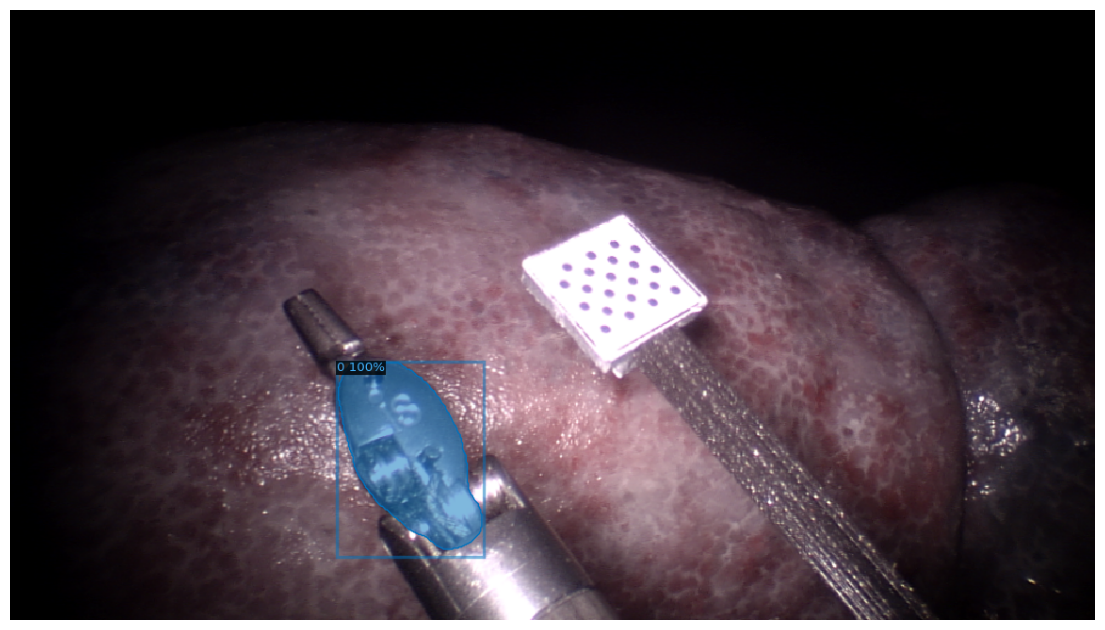

In [3]:
# Load an image
image_path = "/vol/bitbucket/ur23/lnd_new_capture/lnd1_sam6d/rgb/001244.png"
image = cv2.imread(image_path)

# Perform inference
outputs = predictor(image)

# Visualize the results
v = Visualizer(image[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

# Display the image
plt.figure(figsize=(14, 10))
plt.imshow(out.get_image())
cv2.imwrite("mask.png",out.get_image()[:, :, ::-1])
plt.axis('off')
plt.show()


In [4]:
ls

mask.ipynb  mask.png  output/  prepare_data.ipynb


In [5]:
cd ../../

/vol/bitbucket/ur23


In [6]:
ls

4.pth                                gdrnpp_bop2022_buggy/
anaconda3/                           LINEMOD/
Anaconda3-2024.02-1-Linux-x86_64.sh  lnd_new_capture/
clean-pvnet/                         lnd_pvnet_custom_/
cuda/                                lnd_pvnet_custom_resized/
cuda_11.6.1_510.47.03_linux.run*     lnd_pvnet_custom_resized.zip
custom_cat_/                         megapose6d/
detectron2/                          SAM-6D/
download.py                          test/
FoundationPose/                      tmp/
g/                                   unid/
gdrnpp_bop2022/
